# Predicting Change using XGBoost 

From the previous notebook we learnt that the SARIMA is not a good choice for predict change as the cash given by the customer is random (i.e it does not have seasonality or a trend) 

For example : 

Monday:

Some customers give ₹200 for a ₹150 bill
Some give ₹500 for a ₹110 bill
Some have exact cash

Tuesday:

Different customers, different bills, different notes

This does NOT repeat weekly.

There is ZERO seasonality.

## Data Cleaning and Preprocessing

In [18]:
import pandas as pd
import numpy as np

# Load cleaned data (from previous notebook/file)
cleaned_data = pd.read_csv('Cleaned/cleaned_data.csv')

# Quick info
cleaned_data.info()

# Make date column as datetime (use the existing 'Date' column if present)
if 'Date' in cleaned_data.columns:
    cleaned_data['date'] = pd.to_datetime(cleaned_data['Date'])
else:
    cleaned_data['date'] = pd.to_datetime(cleaned_data.index)

# Set the converted 'date' column as index and sort
cleaned_data.set_index('date', inplace=True)
cleaned_data = cleaned_data.sort_index()

# Ensure daily frequency (this may introduce NaNs for missing days)
cleaned_data = cleaned_data.asfreq('D')

# Fill NaNs in 'change_given' with forward-fill then zero (only for this column)
if 'change_given' in cleaned_data.columns:
    cleaned_data['change_given'] = cleaned_data['change_given'].fillna(method='ffill').fillna(0.0)

# Drop the original 'Date' textual column if it exists to avoid leakage
if 'Date' in cleaned_data.columns:
    cleaned_data = cleaned_data.drop(columns=['Date'])

# Show head to confirm
cleaned_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          90 non-null     object 
 1   Day           90 non-null     object 
 2   change_given  90 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.2+ KB


C:\Users\adhis\AppData\Local\Temp\ipykernel_20888\860541114.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data['change_given'] = cleaned_data['change_given'].fillna(method='ffill').fillna(0.0)


,Day,change_given
date,,
2025-08-18,Monday,2177.12
2025-08-19,Tuesday,1775.37
2025-08-20,Wednesday,407.79
2025-08-21,Thursday,3338.79
2025-08-22,Friday,6221.77


In [19]:
# Feature Engineering

cleaned_data["day_of_week"] = cleaned_data.index.dayofweek  #Monday=0, Sunday=6
cleaned_data["month"] = cleaned_data.index.month
cleaned_data["day_of_month"] = cleaned_data.index.day

cleaned_data["is_weekend"] = (cleaned_data["day_of_week"]>=5).astype(int)

# Lag features
cleaned_data["lag1"] = cleaned_data["change_given"].shift(1)
cleaned_data["lag2"] = cleaned_data["change_given"].shift(2)
cleaned_data["lag3"] = cleaned_data["change_given"].shift(3)
cleaned_data["lag7"] = cleaned_data["change_given"].shift(7)

# Rolling averages
cleaned_data["roll3"] = cleaned_data["change_given"].rolling(3).mean()
cleaned_data["roll7"] = cleaned_data["change_given"].rolling(7).mean()

# Rolling standard deviation (volatility)
cleaned_data["roll3_std"] = cleaned_data["change_given"].rolling(3).std()
cleaned_data["roll7_std"] = cleaned_data["change_given"].rolling(7).std()

# Drop rows with NaN from lags/rolling
df_model = cleaned_data.dropna().copy()

df_model

,Day,change_given,day_of_week,month,day_of_month,is_weekend,lag1,lag2,lag3,lag7,roll3,roll7,roll3_std,roll7_std
date,,,,,,,,,,,,,,
2025-08-25,Monday,2579.29,0,8,25,0,4221.12,286.86,6221.77,2177.12,2362.423333,2690.141429,1976.075353,2124.108644
2025-08-26,Tuesday,2302.07,1,8,26,0,2579.29,4221.12,286.86,1775.37,3034.160000,2765.384286,1037.240697,2095.438993
2025-08-27,Wednesday,436.96,2,8,27,0,2302.07,2579.29,4221.12,407.79,1772.773333,2769.551429,1165.122602,2089.991018
2025-08-28,Thursday,502.49,3,8,28,0,436.96,2302.07,2579.29,3338.79,1080.506667,2364.365714,1058.412150,2231.392744
2025-08-29,Friday,662.25,4,8,29,0,502.49,436.96,2302.07,6221.77,533.900000,1570.148571,115.882859,1498.713084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-11,Tuesday,4201.36,1,11,11,0,368.25,1015.17,2825.95,2416.49,1861.593333,2919.070000,2051.952098,2722.477409
2025-11-12,Wednesday,2243.99,2,11,12,0,4201.36,368.25,1015.17,2812.76,2271.200000,2837.817143,1916.699861,2734.639418
2025-11-13,Thursday,1228.64,3,11,13,0,2243.99,4201.36,368.25,931.39,2557.996667,2880.281429,1511.031499,2702.217626


In [20]:
# MODEL TRAINING SPLIT
split = int(len(df_model) * 0.8)

train = df_model.iloc[:split]
test = df_model.iloc[split:]

# Use only numeric columns for features to avoid object dtype leakage
X_train = train.select_dtypes(include=[np.number]).drop(columns=['change_given'], errors='ignore')
y_train = train['change_given'].astype(float)

X_test = test.select_dtypes(include=[np.number]).drop(columns=['change_given'], errors='ignore')
y_test = test['change_given'].astype(float)

print(f"Train rows: {len(train)}, Test rows: {len(test)}")
print('Feature columns:', list(X_train.columns))


Train rows: 66, Test rows: 17
Feature columns: ['day_of_week', 'month', 'day_of_month', 'is_weekend', 'lag1', 'lag2', 'lag3', 'lag7', 'roll3', 'roll7', 'roll3_std', 'roll7_std']


In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


RMSE: 1330.3734465045934
MAE : 959.3021725643383


C:\Users\adhis\AppData\Local\Temp\ipykernel_20888\1147460195.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


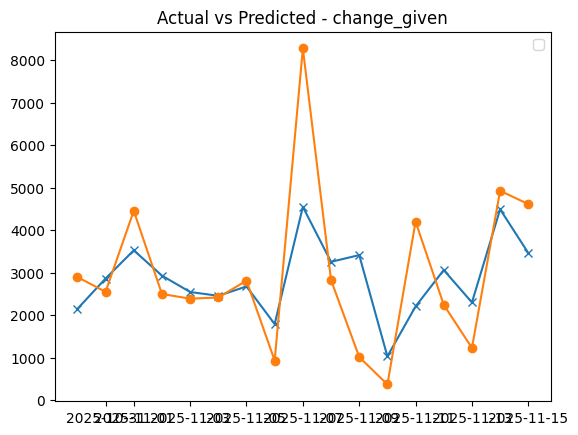

<Figure size 1200x400 with 0 Axes>

In [24]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Predict on test set
pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

plt.show()
plt.tight_layout()
plt.title('Actual vs Predicted - change_given')
plt.legend()
plt.plot(y_test.index, pred, label='predicted', marker='x')
plt.plot(y_test.index, y_test, label='actual', marker='o')
plt.figure(figsize=(12,4))# Plot actual vs predicted for visual checkprint("R2 :", r2)
print("RMSE:", rmse)
print("MAE :", mae)